In [1]:
import pandas as pd
import numpy as np
import os.path as op
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import TensorDataset, DataLoader

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}   

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#torch.set_default_device("cuda")     
#generator = torch.Generator(device="cuda")  

In [3]:
# Input the path to the image data in your computer
img_path = "/mnt/naveens-mac/Stevens FA/FA690 - Machine Learning in Finance/projects/project 1/data"

## Load Images by Year

Sample Period: 1993 to 2019

In [4]:
# Load images in 2017
year = 2017
images = np.memmap(op.join(img_path, f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

In [5]:
print(images.shape) # print the size of the image data
images[0] # print an example image

(67858, 64, 60)


memmap([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0, 255,   0, ...,   0,   0,   0],
        [  0, 255,   0, ...,   0,   0,   0],
        [  0, 255,   0, ...,   0, 255,   0]], dtype=uint8)

## Load Labels

- 'Date': The last day of the 20-day rolling window for the chart.
- 'StockID': CRSP PERMNO that identifies the stock.
- 'MarketCap': Market capitalization in dollar, recorded in thousands.
- 'Ret_{t}d': t=5,20,60, next t-day holding period return.
- 'Ret_month': Holding period return for the next month, from the current monthend to the next monthend.
- 'EWMA_vol': Exponentially weighted volatility (square of daily returns) with alpha as 0.05. One day delay is included.

In [18]:
label_df = pd.read_feather(op.join(img_path, f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


In [19]:
# Create binary prediction target; The objective for this project is to predict the binary price movement for the next five days
label_df['Ret_5d_binary'] = (label_df['Ret_5d'] > 0).astype(int)

In [20]:
print(f"Date range: {label_df['Date'].min()} to {label_df['Date'].max()}") # print the sample period

Date range: 2017-01-31 00:00:00 to 2017-12-29 00:00:00


## Plot the Sample Images

0


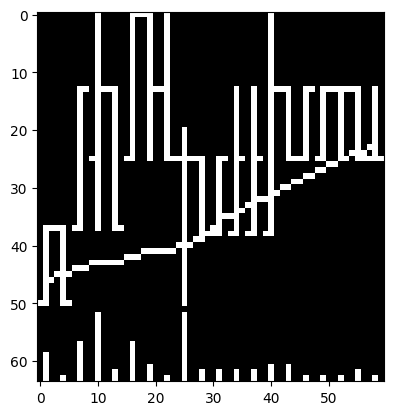

1


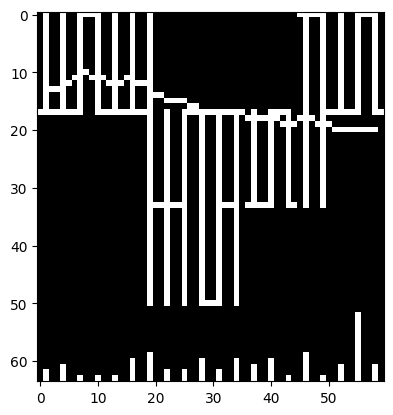

2


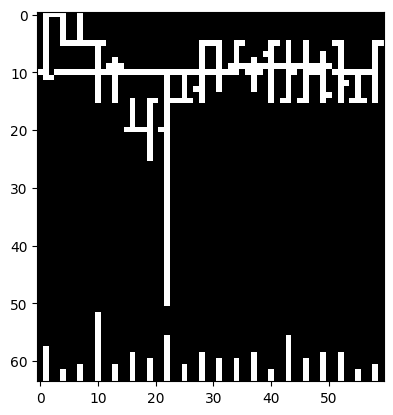

3


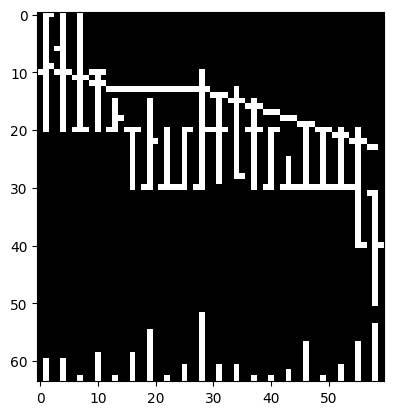

4


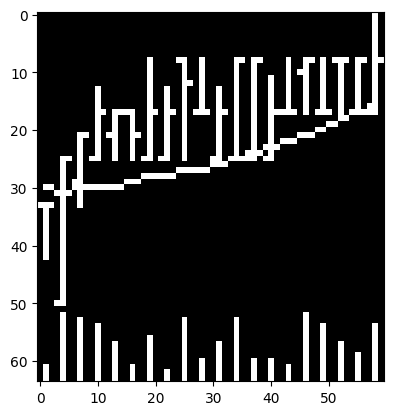

In [21]:
from matplotlib import pyplot as plt
for i in range(5):
    print(i)
    plt.imshow(images[i], cmap='gray')
    plt.show()

In [ ]:
import os
os._exit(00)

In [4]:
import gc
#del X, y, model
#gc.collect()
#torch.cuda.empty_cache()

print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [5]:
start_year = 1993
end_year = 1997

all_images = []
all_labels = []

for year in range(start_year, end_year + 1):
    print(f"Loading data for year {year}...")

    # Load images
    image_file = op.join(img_path, f"20d_month_has_vb_[20]_ma_{year}_images.dat")
    images = np.memmap(image_file, dtype=np.uint8, mode='r').reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    
    # Load labels
    label_file = op.join(img_path, f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
    label_df = pd.read_feather(label_file)
    label_df['Ret_5d_binary'] = (label_df['Ret_5d'] > 0).astype(int)
    
    # Append data
    all_images.append(images)
    all_labels.append(label_df['Ret_5d_binary'].values)

# Concatenate all years
np_images = np.concatenate(all_images, axis=0)
np_labels = np.concatenate(all_labels, axis=0)

print(f"Total images loaded: {np_images.shape[0]}")
print(f"Total labels loaded: {np_labels.shape[0]}")

Loading data for year 1993...
Loading data for year 1994...
Loading data for year 1995...
Loading data for year 1996...
Loading data for year 1997...
Total images loaded: 488386
Total labels loaded: 488386


## Convolutional Neural Network

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [7]:
# Convert to PyTorch tensors
X = torch.tensor(np_images, dtype=torch.float32, device='cuda').unsqueeze(1)  # Add channel dimension
y = torch.tensor(np_labels, dtype=torch.float32, device='cuda')

# Time-Series Split 
tscv = TimeSeriesSplit(n_splits=2,max_train_size=np_images.shape[0] * 0.8)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Further split test set into validation & test (50%-50%)
val_size = len(X_test) // 2
X_val, X_test = X_test[:val_size], X_test[val_size:]
y_val, y_test = y_test[:val_size], y_test[val_size:]

# Create datasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for time-series
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
print((y==0).sum().item())
print((y==1).sum().item())

pos_weight = ((y==0).sum().item() / (y==1).sum().item())
pos_weight

243687
244699


0.9958643067605507

In [12]:
class StockNet(nn.Module):
    def __init__(self):
        super(StockNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 7, 64) 
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # 64x60 -> 32x30
        x = self.pool(nn.functional.relu(self.conv2(x)))  # 32x30 -> 16x15
        x = self.pool(nn.functional.relu(self.conv3(x)))  # 16x15 -> 8x7
        x = x.view(-1, 64 * 8 * 7)  # Flatten to 64*8*7
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [28]:
# Define CNN model
class StockNet(nn.Module):
    def __init__(self):
        super(StockNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.batchnorm1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.batchnorm3=nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)  # New Conv Layer
        self.batchnorm4=nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, padding=2)  # New Conv Layer
        self.batchnorm5=nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Adjusted fully connected layer input size
        self.fc1 = nn.Linear(512 * 2 *1, 256)  # Adjusted for deeper CNN
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.batchnorm1(self.conv1(x))))  # 64x60 -> 32x30
        x = self.pool(self.leaky_relu(self.batchnorm2(self.conv2(x))))  # 32x30 -> 16x15
        x = self.pool(self.leaky_relu(self.batchnorm3(self.conv3(x))))  # 16x15 -> 8x7
        x = self.pool(self.leaky_relu(self.batchnorm4(self.conv4(x))))  # 8x7 -> 4x3
        x = self.pool(self.leaky_relu(self.batchnorm5(self.conv5(x))))  # 4x3 -> 2x1

        x = x.view(-1, 512 * 2 *1)  # Flatten feature maps

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        #x = self.fc3(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [29]:
model = StockNet().to('cuda:0')

In [32]:
# Initialize model, loss, and optimizer
#model = StockNet()

criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001)

# Training loop with validation
num_epochs = 100
train_losses, val_losses, val_accuracy = [], [], []

# Early stopping
min_val_loss = float('inf')
last_min_ind = -1
early_stopping_epoch = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_total=0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda:0'), labels.float().to('cuda:0')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)        
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()
        train_total += labels.size(0)

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    correct=0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda:0'), labels.float().to('cuda:0')
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            val_total += labels.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
           

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracy.append(correct / val_total)

    if val_losses[-1] < min_val_loss:
        last_min_ind = epoch
        min_val_loss = val_losses[-1]
        print(f'min_val_loss:{min_val_loss}')
    elif epoch - last_min_ind >= early_stopping_epoch:
        print(f'Early Stopping Triggered epoch:{epoch}, early_stopping_epoch:{early_stopping_epoch},last_min_ind:{last_min_ind}, min_val_loss:{min_val_loss}')
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}')
    print(f'Val Accuracy: {val_accuracy[-1]:.6f}, Total. Correct: {correct}, Total. test : {val_total}')

min_val_loss:0.7401769123971462
Epoch 1/100, Train Loss: 0.574074, Val Loss: 0.740177
Val Accuracy: 0.543079, Total. Correct: 44205, Total. test : 81397
Epoch 2/100, Train Loss: 0.567077, Val Loss: 0.745534
Val Accuracy: 0.543165, Total. Correct: 44212, Total. test : 81397
Epoch 3/100, Train Loss: 0.563650, Val Loss: 0.748722
Val Accuracy: 0.543054, Total. Correct: 44203, Total. test : 81397
Epoch 4/100, Train Loss: 0.560642, Val Loss: 0.751424
Val Accuracy: 0.543128, Total. Correct: 44209, Total. test : 81397
Epoch 5/100, Train Loss: 0.558063, Val Loss: 0.754035
Val Accuracy: 0.543030, Total. Correct: 44201, Total. test : 81397


KeyboardInterrupt: 

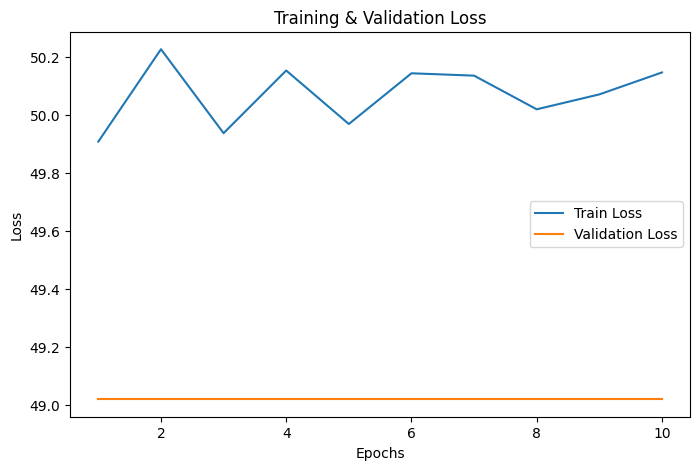

In [94]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [95]:
label_df['Ret_5d_binary'].values

array([1, 1, 0, ..., 0, 1, 1])

In [19]:
# Model Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Test Accuracy: 0.4979
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/home/nnagarajan/anaconda3/envs/fa690/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of misclassified samples: 2719


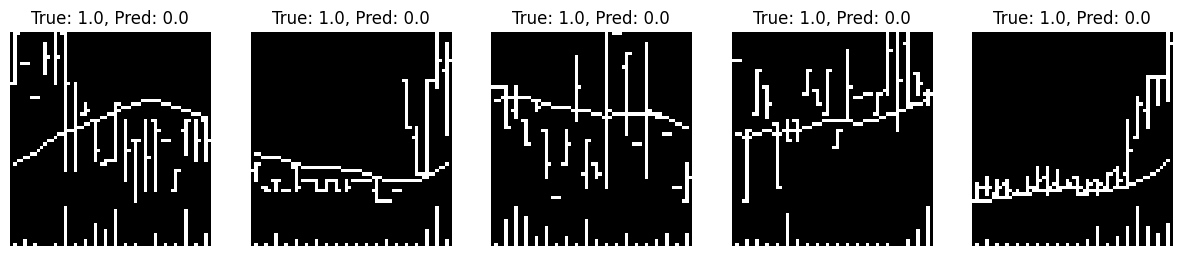

In [52]:
# Analyze misclassified examples
misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
print(f"Number of misclassified samples: {len(misclassified_indices)}")

# Display some misclassified images
num_display = min(5, len(misclassified_indices))
fig, axes = plt.subplots(1, num_display, figsize=(15, 3))

for i, idx in enumerate(misclassified_indices[:num_display]):
    img = X_test[idx].cpu().numpy().squeeze()  # Convert back to NumPy
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
    axes[i].axis('off')

plt.show()